In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from glob import glob
import os

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set(style='ticks', context='notebook', font_scale=1.2)

In [3]:
def get_vipea(fname):
    ip = np.nan
    ea = np.nan
    if os.path.isfile(fname):
        with open(fname, 'r') as f:
            lines = f.readlines()
        if len(lines) < 2:
            print(f'file {fname} is corrupted')
            return ip, ea
    else:
        print(f"file {fname} missing")
        return ip, ea
    
    for line in lines:
        if 'SCC IP (eV)' in line:
            ip = float(line.split()[-1])
        if 'SCC EA (eV)' in line:
            ea = float(line.split()[-1])
                
    if ea is None:
        print(f'missing EA in {fname}')
    if ip is None:
        print(f'missing IP in {fname}')
    return ip, ea


def get_energy(fname):
    # Hartree to kcal/mol
    if os.path.isfile(fname):
        with open(fname, 'r') as f:
            lines = f.readlines()
        if len(lines) < 10:
            print(f'file {fname} is corrupted')
            return np.nan
    else:
        print(f"file {fname} missing")
        return np.nan
    
    line = lines[2].split()
    assert line[0] == 'energy:'
    Eh = float(line[1])
    return Eh
        
    
def calibrate_EA(v):
    # https://pubs.acs.org/doi/pdf/10.1021/acs.jcim.8b00256 (Table 1)
    # -4.44 is to make it relative to SHE
    v = np.array(v)
    v_vs_she = v - 4.44
    return 0.92 * v_vs_she -1.05


def calibrate_IP(v):
    # https://pubs.acs.org/doi/pdf/10.1021/acs.jcim.8b00256 (Table 1)
    # -4.44 is to make it relative to SHE
    v = np.array(v)
    v_vs_she = v - 4.44
    return 0.91 * v_vs_she + 0.15


def boltzmann_weights(E):
    """E = energyes in Hartee"""
    E = np.array(E) - np.array(E).min()
    kBT = 0.000944184867644271  # in Hartree, at 298.15 K
    Bw = np.exp(-E/kBT) / np.sum(np.exp(-E/kBT))  # weights
    return Bw


def boltzmann_average(values, E, return_stderr=False):
    """
    values = property values
    E = energyes in Hartee
    """
    values = np.array(values)
    Bw = boltzmann_weights(E)
    if return_stderr:
        return weighted_mean_and_stderr(values, Bw)  # weighted average, weighted std err
    else:
        return np.sum(values * Bw)  # weighted average


def weighted_mean_and_stderr(x, w):
    """
    x: values
    w: weights
    """
    x = np.array(x)
    w = np.array(w)
    n_eff = np.sum(w)**2 / np.sum(w**2)
    x_w_mean = np.average(x, weights=w)
    x_w_variance = (n_eff / (n_eff - 1)) * (np.sum(w * (x - x_w_mean)**2) / np.sum(w))
    w_std_err = np.sqrt(x_w_variance / n_eff)
    return x_w_mean,  w_std_err

# Parse xTB data and put into tables
------------

In [127]:
# =================
# Create DataFrame
# =================

comp = '4A_4B' # {'4A_4B', '6A_2B', '2A_6B'}
iA = 8  # [0,8]
iBs = list(range(682))

# 4A_4B --> 2046 polymers
# 6A_2B, 2A_6B --> 1364 polymers

dlist = []
for iB in iBs:
    poly_id = f"{iA}_{iB}"
    for poly_type  in ['alternating', 'block', 'random']:
        for log in glob(f'{comp}/{poly_id}/{poly_type}/vipea*log'):
            seq_id = log.split('.')[0].split('/')[-1].split('_')[1]  # sequence ID
            cfm_id = log.split('.')[0].split('/')[-1].split('_')[2]  # conformer ID
            ip, ea = get_vipea(log)  # get IP and EA results
            energy = get_energy(f'{comp}/{poly_id}/{poly_type}/xtbopt_{seq_id}_{cfm_id}.mol')
            # save dict in list
            d = {'IP (eV)':ip, 'EA (eV)':ea, 'energy (Eh)':energy, 
                 'poly_id':poly_id, 'comp':comp, 'poly_type':poly_type, 'seq_id':seq_id, 'cfm_id':cfm_id}
            dlist.append(d)

df = pd.DataFrame({key: [i[key] for i in dlist] for key in dlist[0]})

num_na = sum(df.loc[:, 'IP (eV)'].isnull()) + sum(df.loc[:, 'energy (Eh)'].isnull())
print(f"{num_na} NaN entries")

df

0 NaN entries


,IP (eV),EA (eV),energy (Eh),poly_id,comp,poly_type,seq_id,cfm_id
0,6.1471,2.5682,-243.998373,8_0,2A_6B,block,00,06
1,6.0210,2.5011,-244.001400,8_0,2A_6B,block,00,00
2,6.0251,2.5875,-244.005407,8_0,2A_6B,block,00,05
3,6.0589,2.5641,-243.997480,8_0,2A_6B,block,00,01
4,6.1772,2.5383,-244.001920,8_0,2A_6B,block,00,02
...,...,...,...,...,...,...,...,...
200755,5.3883,2.2046,-191.297664,8_681,2A_6B,random,05,04
200756,5.4256,2.2967,-191.302151,8_681,2A_6B,random,03,03
200757,5.3963,2.2345,-191.296773,8_681,2A_6B,random,14,01
200758,5.3486,2.4074,-191.297403,8_681,2A_6B,random,00,03


In [128]:
# ============================
# Boltzmann average properties
# ============================

dlist = []

for iB in iBs:
    poly_id = f"{iA}_{iB}"
    mask0 = df.loc[:, 'poly_id'] == poly_id
    mask1 = df.loc[:, 'comp'] == comp
    mask = np.logical_and(mask0, mask1)
    df0 = df.loc[mask, :]
    for poly_type  in ['alternating', 'block', 'random']:
        mask = df0.loc[:, 'poly_type'] == poly_type
        df1 = df0.loc[mask, :]
        seq_ids = sorted(list(set(df1.loc[:, 'seq_id'])))
        for seq_id in seq_ids:
            mask = df1.loc[:, 'seq_id'] == seq_id
            df2 = df1.loc[mask, :]
                
            # get relevant info
            energies = df2.loc[:, 'energy (Eh)']
            IP = df2.loc[:, 'IP (eV)']
            EA = df2.loc[:, 'EA (eV)']
                
            # get weighted properties
            wIP = boltzmann_average(IP, energies, return_stderr=False)
            wEA = boltzmann_average(EA, energies, return_stderr=False)
                    
            # save dict in list
            d = {'IP (eV)':wIP, 'EA (eV)':wEA, 'poly_id':poly_id, 'comp':comp, 'poly_type':poly_type, 'seq_id':seq_id}
            dlist.append(d)
                
dff = pd.DataFrame({key: [i[key] for i in dlist] for key in dlist[0]})

num_na = sum(dff.loc[:, 'IP (eV)'].isnull()) + sum(dff.loc[:, 'EA (eV)'].isnull())
print(f"{num_na} NaN entries")

dff

0 NaN entries


,IP (eV),EA (eV),poly_id,comp,poly_type,seq_id
0,6.024170,2.569105,8_0,2A_6B,block,00
1,6.016756,2.421882,8_0,2A_6B,random,00
2,6.012149,2.496765,8_0,2A_6B,random,01
3,6.059037,2.481349,8_0,2A_6B,random,02
4,6.099495,2.541809,8_0,2A_6B,random,03
...,...,...,...,...,...,...
25090,5.319593,2.455365,8_681,2A_6B,random,11
25091,5.374626,2.259399,8_681,2A_6B,random,12
25092,5.393492,2.284475,8_681,2A_6B,random,13
25093,5.315171,2.237527,8_681,2A_6B,random,14


In [129]:
# ==================================
# Average properties over sequences
# ==================================

comp2polytypes = {'4A_4B': ['alternating', 'block', 'random'], 
                  '6A_2B': ['block', 'random'],
                  '2A_6B': ['block', 'random']}
dlist = []

for iB in iBs:
    poly_id = f"{iA}_{iB}"
    mask0 = dff.loc[:, 'poly_id'] == poly_id
    mask1 = dff.loc[:, 'comp'] == comp
    mask = np.logical_and(mask0, mask1)
    df0 = dff.loc[mask, :]
        
    for poly_type  in comp2polytypes[comp]:
        IP = None
        EA = None
                
        mask = df0.loc[:, 'poly_type'] == poly_type
        df1 = df0.loc[mask, :]

        # get relevant info
        IP = np.mean(df1.loc[:, 'IP (eV)'])
        EA = np.mean(df1.loc[:, 'EA (eV)'])
                
        # save dict in list
        d = {'IP (eV)':IP, 'EA (eV)':EA, 'poly_id':poly_id, 'comp':comp, 'poly_type':poly_type}
        dlist.append(d)
            
dfff = pd.DataFrame({key: [i[key] for i in dlist] for key in dlist[0]})

num_na = sum(dfff.loc[:, 'IP (eV)'].isnull()) + sum(dfff.loc[:, 'EA (eV)'].isnull())
print(f"{num_na} NaN entries")

dfff

0 NaN entries


,IP (eV),EA (eV),poly_id,comp,poly_type
0,6.024170,2.569105,8_0,2A_6B,block
1,6.047168,2.478935,8_0,2A_6B,random
2,6.799401,3.105018,8_1,2A_6B,block
3,6.837557,3.101940,8_1,2A_6B,random
4,5.704008,2.493771,8_2,2A_6B,block
...,...,...,...,...,...
1359,7.057488,4.095619,8_679,2A_6B,random
1360,5.874810,2.554801,8_680,2A_6B,block
1361,5.948941,2.470584,8_680,2A_6B,random
1362,5.308416,2.438739,8_681,2A_6B,block


In [130]:
# ===========
# save to CSV
# ===========

dfff.to_csv(f'{comp}/{iA}_parsed_data.csv', index=False)

# Aggregate data and create overall dataset
-------------------

In [4]:
comps = ['4A_4B', '6A_2B', '2A_6B']
iAs = [0,1,2,3,4,5,6,7,8]

df = pd.DataFrame(columns=['IP (eV)', 'EA (eV)', 'poly_id', 'comp', 'poly_type'])
for comp in comps:
    for iA in iAs:
        df_i = pd.read_csv(f'{comp}/{iA}_parsed_data.csv')
        df = df.append(df_i)
        
df = df.reset_index(drop=True)
df

,IP (eV),EA (eV),poly_id,comp,poly_type
0,6.261997,1.878902,0_0,4A_4B,alternating
1,6.210397,2.329229,0_0,4A_4B,block
2,6.272161,2.106772,0_0,4A_4B,random
3,7.170897,2.893603,0_1,4A_4B,alternating
4,7.142086,2.896976,0_1,4A_4B,block
...,...,...,...,...,...
42961,7.057488,4.095619,8_679,2A_6B,random
42962,5.874810,2.554801,8_680,2A_6B,block
42963,5.948941,2.470584,8_680,2A_6B,random
42964,5.308416,2.438739,8_681,2A_6B,block


In [5]:
# ===============================
# collate data and create dataset
# ===============================

comp2fracA = {'4A_4B':0.5, '6A_2B':0.75, '2A_6B':0.25}
fracA = [comp2fracA[c] for c in df.loc[:, 'comp']]
fracB = 1. - np.array(fracA)

df_out = df.loc[:, ['poly_id', 'poly_type', 'comp']]
df_out.loc[:, 'fracA'] = fracA
df_out.loc[:, 'fracB'] = fracB
df_out.loc[:, 'EA (eV)'] = df.loc[:, 'EA (eV)']
df_out.loc[:, 'IP (eV)'] = df.loc[:, 'IP (eV)']
df_out.loc[:, 'EA vs SHE (eV)'] = calibrate_EA(df_out.loc[:, 'EA (eV)'])
df_out.loc[:, 'IP vs SHE (eV)'] = calibrate_IP(df_out.loc[:, 'IP (eV)'])

df_out

,poly_id,poly_type,comp,fracA,fracB,EA (eV),IP (eV),EA vs SHE (eV),IP vs SHE (eV)
0,0_0,alternating,4A_4B,0.50,0.50,1.878902,6.261997,-3.406210,1.808017
1,0_0,block,4A_4B,0.50,0.50,2.329229,6.210397,-2.991909,1.761062
2,0_0,random,4A_4B,0.50,0.50,2.106772,6.272161,-3.196570,1.817267
3,0_1,alternating,4A_4B,0.50,0.50,2.893603,7.170897,-2.472685,2.635116
4,0_1,block,4A_4B,0.50,0.50,2.896976,7.142086,-2.469582,2.608899
...,...,...,...,...,...,...,...,...,...
42961,8_679,random,2A_6B,0.25,0.75,4.095619,7.057488,-1.366831,2.531914
42962,8_680,block,2A_6B,0.25,0.75,2.554801,5.874810,-2.784383,1.455677
42963,8_680,random,2A_6B,0.25,0.75,2.470584,5.948941,-2.861863,1.523136
42964,8_681,block,2A_6B,0.25,0.75,2.438739,5.308416,-2.891160,0.940259


In [6]:
monoA = pd.read_csv('../acids.csv')
monoB = pd.read_csv('../bromides.csv')

# get monomer smiles based on polymer ID
df_out.loc[:, 'monoA'] = [monoA.loc[int(ii.split('_')[0]), '0'] for ii in df_out.loc[:, 'poly_id']]
df_out.loc[:, 'monoB'] = [monoB.loc[int(ii.split('_')[1]), '0'] for ii in df_out.loc[:, 'poly_id']]

df_out

,poly_id,poly_type,comp,fracA,fracB,EA (eV),IP (eV),EA vs SHE (eV),IP vs SHE (eV),monoA,monoB
0,0_0,alternating,4A_4B,0.50,0.50,1.878902,6.261997,-3.406210,1.808017,OB(O)c1cc(F)c(B(O)O)cc1F,Oc1cc(O)c(Br)c(O)c1Br
1,0_0,block,4A_4B,0.50,0.50,2.329229,6.210397,-2.991909,1.761062,OB(O)c1cc(F)c(B(O)O)cc1F,Oc1cc(O)c(Br)c(O)c1Br
2,0_0,random,4A_4B,0.50,0.50,2.106772,6.272161,-3.196570,1.817267,OB(O)c1cc(F)c(B(O)O)cc1F,Oc1cc(O)c(Br)c(O)c1Br
3,0_1,alternating,4A_4B,0.50,0.50,2.893603,7.170897,-2.472685,2.635116,OB(O)c1cc(F)c(B(O)O)cc1F,N#Cc1cc(Br)c(F)cc1Br
4,0_1,block,4A_4B,0.50,0.50,2.896976,7.142086,-2.469582,2.608899,OB(O)c1cc(F)c(B(O)O)cc1F,N#Cc1cc(Br)c(F)cc1Br
...,...,...,...,...,...,...,...,...,...,...,...
42961,8_679,random,2A_6B,0.25,0.75,4.095619,7.057488,-1.366831,2.531914,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21,O=[N+]([O-])c1ncc(Br)cc1Br
42962,8_680,block,2A_6B,0.25,0.75,2.554801,5.874810,-2.784383,1.455677,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21,CC(Oc1ccc(Br)cc1Br)C(=O)NN
42963,8_680,random,2A_6B,0.25,0.75,2.470584,5.948941,-2.861863,1.523136,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21,CC(Oc1ccc(Br)cc1Br)C(=O)NN
42964,8_681,block,2A_6B,0.25,0.75,2.438739,5.308416,-2.891160,0.940259,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21,Nc1cc(Br)ccc1Br


In [7]:
df_out.to_csv('../dataset.csv', index=False)

# Property distributions
-----------

In [8]:
df = df_out
df.loc[:, 'monoA_ID'] = [s.split('_')[0] for s in df.loc[:, 'poly_id']]

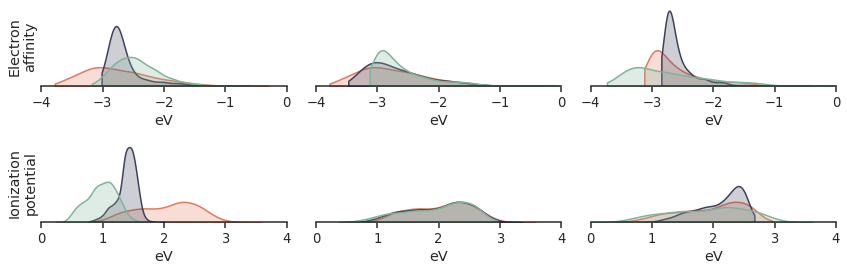

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,4), sharey=True, sharex='row')

colors = ['#e07a5f','#3d405b','#81b29a']
linewidth = 1.5

def mykdeplots(dfs, axes, col, labels, colors, rug=False, linewidth=1):
    for df, l, c in zip(dfs, labels, colors):
        sns.kdeplot(df.loc[:, 'EA vs SHE (eV)'], fill=True, cut=0, ax=axes[0,col], label=l, color=c, linewidth=linewidth)
        sns.kdeplot(df.loc[:, 'IP vs SHE (eV)'], fill=True, cut=0, ax=axes[1,col], color=c, linewidth=linewidth)
        if rug is True:
            sns.rugplot(df.loc[:, 'EA vs SHE (eV)'], ax=axes[0,col], color=c)
            sns.rugplot(df.loc[:, 'IP vs SHE (eV)'], ax=axes[1,col], color=c)
        
        
# --------------
# Monomers Comp
# --------------
mask = ((df.loc[:, 'monoA_ID'] == '0') & 
        (df.loc[:, 'poly_type'] == 'alternating') & 
        (df.loc[:, 'comp'] == '4A_4B'))
df0 = df.loc[mask, :]

mask = ((df.loc[:, 'monoA_ID'] == '1') & 
        (df.loc[:, 'poly_type'] == 'alternating') & 
        (df.loc[:, 'comp'] == '4A_4B'))
df1 = df.loc[mask, :]

mask = ((df.loc[:, 'monoA_ID'] == '2') & 
        (df.loc[:, 'poly_type'] == 'alternating') & 
        (df.loc[:, 'comp'] == '4A_4B'))
df2 = df.loc[mask, :]

mykdeplots(dfs=[df0, df1, df2], axes=axes, col=0, labels=['id0', 'id1', 'id2'], colors=colors, linewidth=linewidth)

# --------------
# Sequence
# --------------
mask = ((df.loc[:, 'monoA_ID'] == '0') & 
        (df.loc[:, 'poly_type'] == 'alternating') & 
        (df.loc[:, 'comp'] == '4A_4B'))
df0 = df.loc[mask, :]

mask = ((df.loc[:, 'monoA_ID'] == '0') & 
        (df.loc[:, 'poly_type'] == 'random') & 
        (df.loc[:, 'comp'] == '4A_4B'))
df1 = df.loc[mask, :]

mask = ((df.loc[:, 'monoA_ID'] == '0') & 
        (df.loc[:, 'poly_type'] == 'block') & 
        (df.loc[:, 'comp'] == '4A_4B'))
df2 = df.loc[mask, :]

mykdeplots(dfs=[df0, df1, df2], axes=axes, col=1, labels=['Alternating', 'Random', 'Block'], colors=colors, linewidth=linewidth)

# --------------
# Stoichiometry
# --------------
mask = ((df.loc[:, 'monoA_ID'] == '0') & 
        (df.loc[:, 'poly_type'] == 'block') & 
        (df.loc[:, 'comp'] == '4A_4B'))
df0 = df.loc[mask, :]

mask = ((df.loc[:, 'monoA_ID'] == '0') & 
        (df.loc[:, 'poly_type'] == 'block') & 
        (df.loc[:, 'comp'] == '6A_2B'))
df1 = df.loc[mask, :]

mask = ((df.loc[:, 'monoA_ID'] == '0') & 
        (df.loc[:, 'poly_type'] == 'block') & 
        (df.loc[:, 'comp'] == '2A_6B'))
df2 = df.loc[mask, :]
 
mykdeplots(dfs=[df0, df1, df2], axes=axes, col=2, labels=['1:1', '1:3', '3:1'], colors=colors, linewidth=linewidth)

# labels
for i in range(2):
    axes[i,0].set_ylabel('')
    axes[i,0].set_yticks([])
    for j in range(3):
        axes[i,j].spines['top'].set_visible(False)
        axes[i,j].spines['left'].set_visible(False)
        axes[i,j].spines['right'].set_visible(False)
        
        axes[i,j].tick_params(width=linewidth)
        axes[i,j].spines['bottom'].set_linewidth(linewidth)
        
        axes[i,j].set_xlabel('eV')
    
axes[0,0].set_ylabel('Electron\naffinity')
axes[1,0].set_ylabel('Ionization\npotential')

_ = axes[0,0].set_xlim([-4,0])
_ = axes[0,0].set_xticks([-4,-3,-2,-1,0])

_ = axes[1,0].set_xlim([0,4])
_ = axes[1,0].set_xticks([0,1,2,3,4])

for i in range(2):
    for j in range(3):
        axes[i,j].set_xlabel('eV')

# Legends
#axes[0,0].legend(frameon=False)
#axes[0,1].legend(frameon=False)
#axes[0,2].legend(frameon=False)

plt.tight_layout()